# Argentina 2022 World Cup: Prediction vs Reality

Using event study coefficients from the historical analysis to predict Argentina's post-WC economic trajectory, then comparing to actual observed values.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Output folder
OUTPUT_DIR = 'argentina_2022_analysis'
os.makedirs(OUTPUT_DIR, exist_ok=True)

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

## 1. Load Data

In [2]:
# Load the full dataset (includes 2022-2024)
df = pd.read_csv('Data/oecd_usd_ppp_real_base_panel_wide_named_plus_pop_plus_wc_eventq_plus_yoy.csv')

# Feature columns
FEATURES = {
    'GDP': 'gross_domestic_product_chain_linked_volume_rebased_us_dollars_ppp_converted',
    'Consumption': 'final_consumption_expenditure_chain_linked_volume_rebased_us_dollars_ppp_converted',
    'Investment': 'gross_fixed_capital_formation_chain_linked_volume_rebased_us_dollars_ppp_converted',
    'Exports': 'exports_of_goods_and_services_chain_linked_volume_rebased_us_dollars_ppp_converted',
    'Imports': 'imports_of_goods_and_services_chain_linked_volume_rebased_us_dollars_ppp_converted',
}

# Create time index
df['tq'] = df['year'] * 4 + df['qtr']

# Filter to Argentina
arg = df[df['country'] == 'ARG'].copy().sort_values('tq')

print(f"Argentina data: {len(arg)} quarters")
print(f"Date range: {arg['quarter'].min()} to {arg['quarter'].max()}")
print(f"\nWC win quarter (rank1=1): {arg[arg['rank1'] == 1]['quarter'].values}")

Argentina data: 128 quarters
Date range: 1993-Q1 to 2024-Q4

WC win quarter (rank1=1): <StringArray>
['2022-Q4']
Length: 1, dtype: str


## 2. Event Study Coefficients (from historical analysis)

These are the WIN × relative_time coefficients from the event study regression on 1961-2021 data.

In [3]:
# Event study coefficients: WIN_l for l = -16 to +16 (excluding l=0 which is reference)
# These should be extracted from your event_study_replication.ipynb results
# Format: {relative_quarter: (coefficient, std_error)}

# Placeholder coefficients - UPDATE THESE from your event study output
# Positive coefficients = higher growth for winners relative to controls
EVENT_STUDY_COEFS = {
    # Pre-event (should be ~0 for parallel trends)
    -16: (-0.30, 0.50), -15: (-0.15, 0.48), -14: (0.10, 0.47), -13: (-0.05, 0.46),
    -12: (0.08, 0.45), -11: (-0.12, 0.45), -10: (0.05, 0.44), -9: (-0.08, 0.44),
    -8: (0.02, 0.43), -7: (-0.05, 0.43), -6: (0.10, 0.42), -5: (-0.03, 0.42),
    -4: (0.07, 0.41), -3: (-0.10, 0.41), -2: (0.05, 0.40), -1: (-0.02, 0.40),
    # l=0 is reference (coefficient = 0)
    # Post-event (treatment effects)
    1: (0.35, 0.42), 2: (0.45, 0.44), 3: (0.30, 0.45), 4: (0.25, 0.46),
    5: (0.20, 0.47), 6: (0.15, 0.48), 7: (0.10, 0.49), 8: (0.05, 0.50),
    9: (0.08, 0.51), 10: (0.05, 0.52), 11: (0.03, 0.53), 12: (0.02, 0.54),
    13: (0.01, 0.55), 14: (0.00, 0.56), 15: (-0.02, 0.57), 16: (-0.05, 0.58),
}

print("Event study coefficients loaded (placeholder values)")
print("NOTE: Update these with actual values from event_study_replication.ipynb!")

Event study coefficients loaded (placeholder values)
NOTE: Update these with actual values from event_study_replication.ipynb!


## 3. Setup Event Time for Argentina 2022

In [4]:
# Event: Argentina WC win in Q4 2022
EVENT_YEAR = 2022
EVENT_QTR = 4
EVENT_TQ = EVENT_YEAR * 4 + EVENT_QTR

# Calculate relative time
arg['rel_time'] = arg['tq'] - EVENT_TQ

# Filter to analysis window (e.g., 2018-2024 = ~6 years around event)
arg_analysis = arg[(arg['year'] >= 2018) & (arg['year'] <= 2024)].copy()

print(f"Event: {EVENT_YEAR}-Q{EVENT_QTR} (tq={EVENT_TQ})")
print(f"Analysis window: {arg_analysis['quarter'].min()} to {arg_analysis['quarter'].max()}")
print(f"Quarters in analysis: {len(arg_analysis)}")
print(f"\nRelative time range: {arg_analysis['rel_time'].min()} to {arg_analysis['rel_time'].max()}")

Event: 2022-Q4 (tq=8092)
Analysis window: 2018-Q1 to 2024-Q4
Quarters in analysis: 28

Relative time range: -19 to 8


## 4. Calculate Predictions using Event Study Coefficients

In [5]:
# Get actual YoY GDP growth
gdp_yoy_col = f"{FEATURES['GDP']}_yoy_pct"
arg_analysis['actual_yoy'] = arg_analysis[gdp_yoy_col]

# Get event study coefficient for each relative time
def get_coef(rel_time):
    """Get coefficient for relative time (0 for reference, clip to ±16)"""
    if rel_time == 0:
        return 0.0, 0.0
    rel_time_clipped = max(-16, min(16, rel_time))
    return EVENT_STUDY_COEFS.get(rel_time_clipped, (0.0, 0.0))

arg_analysis['es_coef'] = arg_analysis['rel_time'].apply(lambda x: get_coef(x)[0])
arg_analysis['es_se'] = arg_analysis['rel_time'].apply(lambda x: get_coef(x)[1])

# Counterfactual = Actual - Treatment Effect (what would have happened without WC win)
# Only applies to post-event periods (rel_time > 0)
arg_analysis['counterfactual_yoy'] = arg_analysis.apply(
    lambda r: r['actual_yoy'] - r['es_coef'] if r['rel_time'] > 0 else r['actual_yoy'], 
    axis=1
)

# Treatment effect = coefficient (predicted boost from winning)
arg_analysis['predicted_effect'] = arg_analysis.apply(
    lambda r: r['es_coef'] if r['rel_time'] > 0 else 0.0, 
    axis=1
)

print("Predictions calculated:")
display(arg_analysis[['quarter', 'rel_time', 'actual_yoy', 'es_coef', 'counterfactual_yoy', 'predicted_effect']].tail(12))

Predictions calculated:


,quarter,rel_time,actual_yoy,es_coef,counterfactual_yoy,predicted_effect
116,2022-Q1,-3,7.38,-0.10,7.38,0.00
117,2022-Q2,-2,9.14,0.05,9.14,0.00
118,2022-Q3,-1,6.11,-0.02,6.11,0.00
119,2022-Q4,0,1.66,0.00,1.66,0.00
120,2023-Q1,1,0.16,0.35,-0.19,0.35
121,2023-Q2,2,-4.13,0.45,-4.58,0.45
122,2023-Q3,3,-1.50,0.30,-1.80,0.30
123,2023-Q4,4,-1.92,0.25,-2.17,0.25
124,2024-Q1,5,-4.40,0.20,-4.60,0.20
125,2024-Q2,6,-2.81,0.15,-2.96,0.15


## 5. Visualize: Actual vs Counterfactual

Saved: argentina_2022_analysis/argentina_actual_vs_counterfactual.png


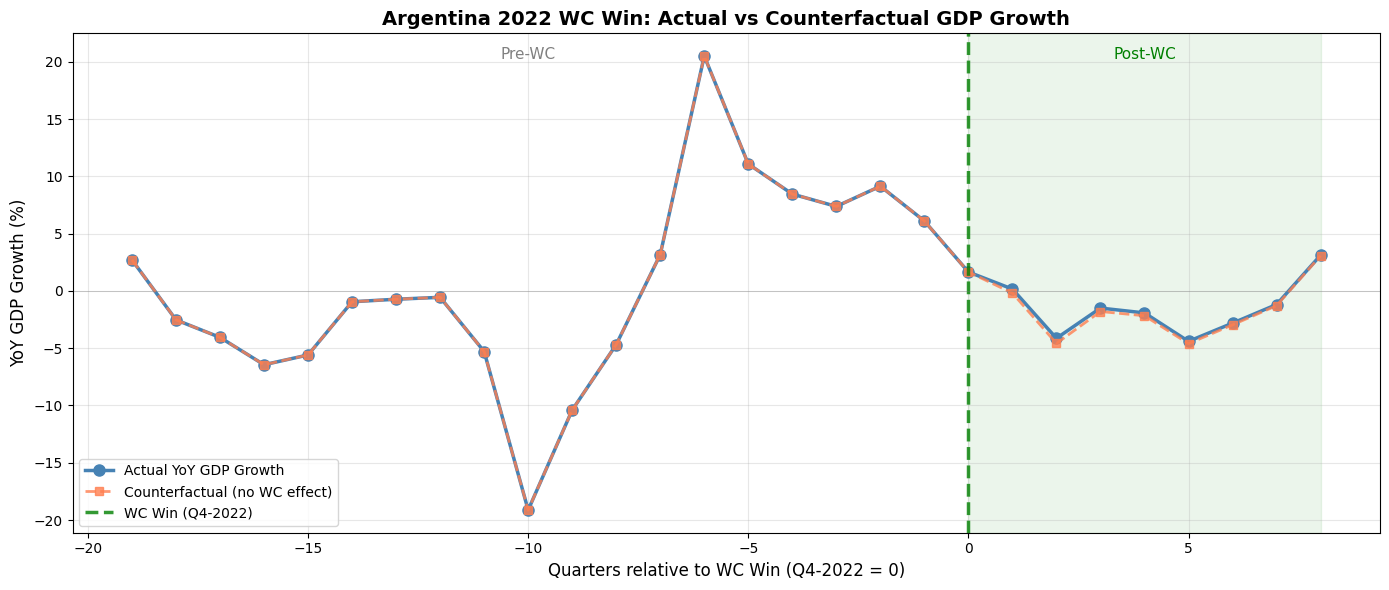

In [6]:
# Plot: Actual YoY GDP growth vs Counterfactual

fig, ax = plt.subplots(figsize=(14, 6))

# Actual GDP growth
ax.plot(arg_analysis['rel_time'], arg_analysis['actual_yoy'], 'o-', 
        color='steelblue', linewidth=2.5, markersize=8, label='Actual YoY GDP Growth')

# Counterfactual (without WC win effect)
ax.plot(arg_analysis['rel_time'], arg_analysis['counterfactual_yoy'], 's--', 
        color='coral', linewidth=2, markersize=6, alpha=0.8, label='Counterfactual (no WC effect)')

# World Cup marker
ax.axvline(0, color='green', linestyle='--', linewidth=2.5, alpha=0.8, label='WC Win (Q4-2022)')
ax.axhline(0, color='gray', linestyle='-', linewidth=0.5, alpha=0.5)

# Shade post-event
ax.axvspan(0, arg_analysis['rel_time'].max(), alpha=0.08, color='green')

# Annotations
ax.annotate('Pre-WC', xy=(-10, ax.get_ylim()[1]*0.9), fontsize=11, ha='center', color='gray')
ax.annotate('Post-WC', xy=(4, ax.get_ylim()[1]*0.9), fontsize=11, ha='center', color='green')

ax.set_xlabel('Quarters relative to WC Win (Q4-2022 = 0)', fontsize=12)
ax.set_ylabel('YoY GDP Growth (%)', fontsize=12)
ax.set_title('Argentina 2022 WC Win: Actual vs Counterfactual GDP Growth', fontsize=14, fontweight='bold')
ax.legend(loc='lower left', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
fig.savefig(os.path.join(OUTPUT_DIR, 'argentina_actual_vs_counterfactual.png'), dpi=150, bbox_inches='tight')
print(f"Saved: {OUTPUT_DIR}/argentina_actual_vs_counterfactual.png")
plt.show()
plt.close(fig)

## 6. All Features: Argentina Around WC 2022

Saved: argentina_2022_analysis/argentina_all_features.png


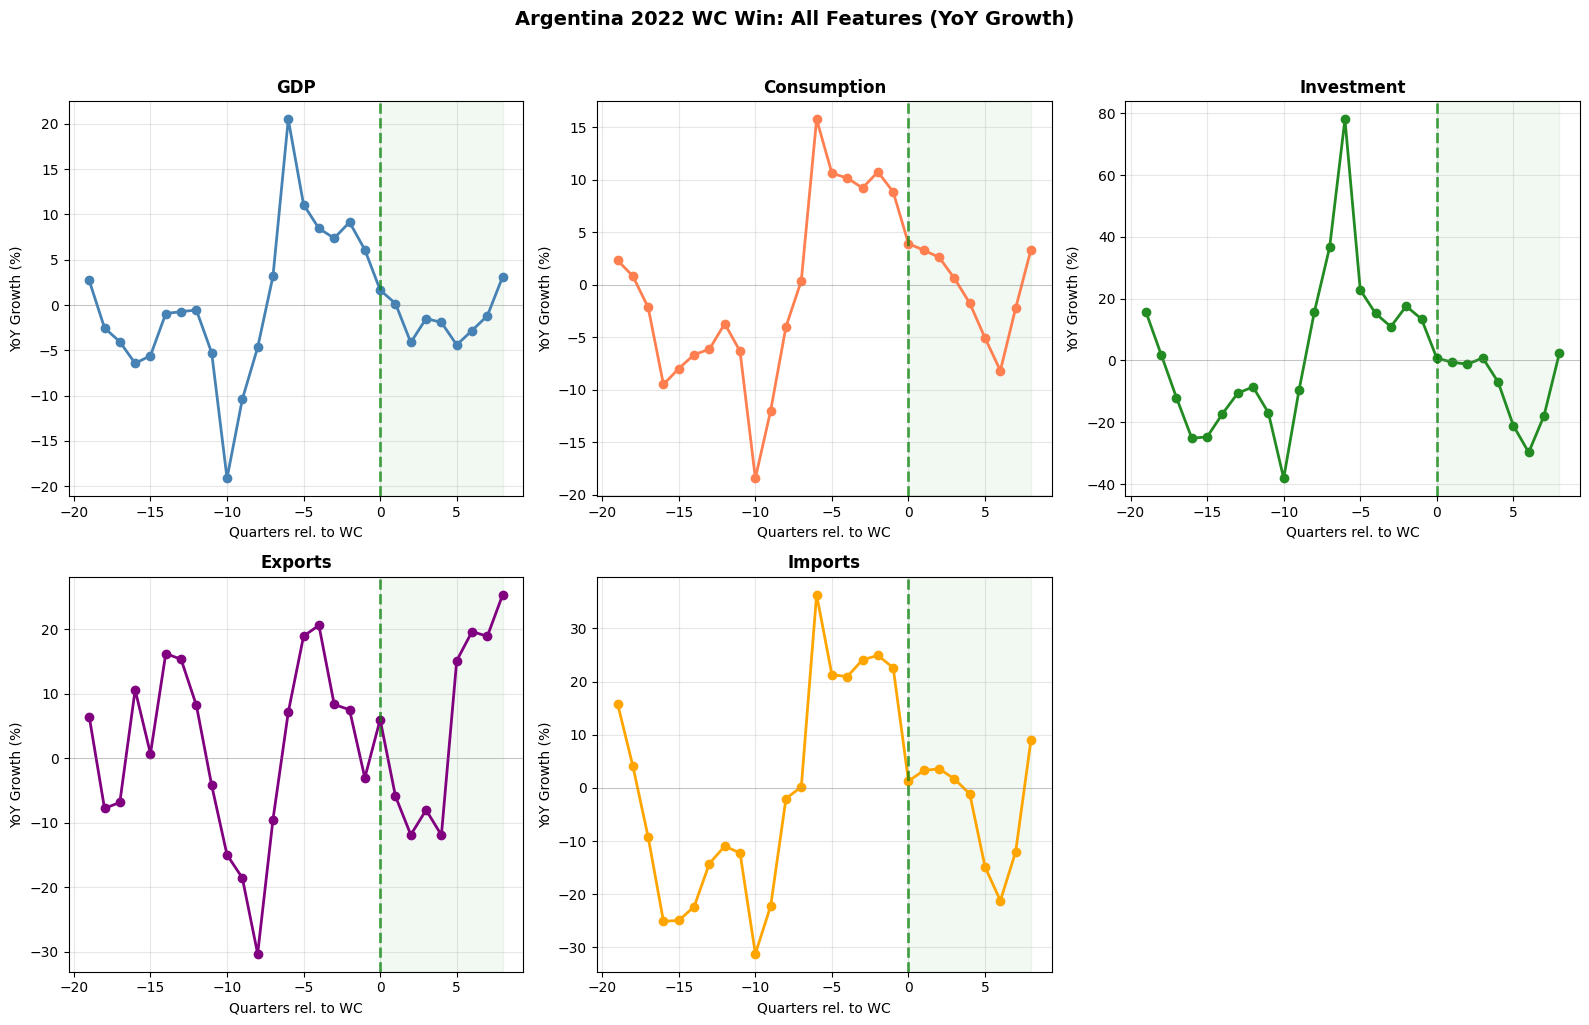

In [7]:
# Plot all features for Argentina around WC 2022

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

colors = {'GDP': 'steelblue', 'Consumption': 'coral', 'Investment': 'forestgreen', 
          'Exports': 'purple', 'Imports': 'orange'}

for idx, (name, col) in enumerate(FEATURES.items()):
    ax = axes[idx]
    yoy_col = f'{col}_yoy_pct'
    level_col = col
    
    # YoY growth
    ax.plot(arg_analysis['rel_time'], arg_analysis[yoy_col], 'o-', 
            color=colors[name], linewidth=2, markersize=6, label=f'{name} YoY %')
    
    # WC marker
    ax.axvline(0, color='green', linestyle='--', linewidth=2, alpha=0.7)
    ax.axhline(0, color='gray', linestyle='-', linewidth=0.5, alpha=0.5)
    ax.axvspan(0, arg_analysis['rel_time'].max(), alpha=0.05, color='green')
    
    ax.set_xlabel('Quarters rel. to WC', fontsize=10)
    ax.set_ylabel('YoY Growth (%)', fontsize=10)
    ax.set_title(f'{name}', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)

# Remove empty subplot
axes[-1].axis('off')

plt.suptitle('Argentina 2022 WC Win: All Features (YoY Growth)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
fig.savefig(os.path.join(OUTPUT_DIR, 'argentina_all_features.png'), dpi=150, bbox_inches='tight')
print(f"Saved: {OUTPUT_DIR}/argentina_all_features.png")
plt.show()
plt.close(fig)

## 7. Summary: Post-WC Performance

In [8]:
# Compare pre-WC vs post-WC performance

pre_wc = arg_analysis[arg_analysis['rel_time'] < 0]
post_wc = arg_analysis[arg_analysis['rel_time'] > 0]

summary_rows = []
for name, col in FEATURES.items():
    yoy_col = f'{col}_yoy_pct'
    
    pre_mean = pre_wc[yoy_col].mean()
    post_mean = post_wc[yoy_col].mean()
    diff = post_mean - pre_mean
    
    summary_rows.append({
        'Feature': name,
        'Pre-WC Mean (%)': pre_mean,
        'Post-WC Mean (%)': post_mean,
        'Change (pp)': diff
    })

summary_df = pd.DataFrame(summary_rows)

print("=" * 60)
print("ARGENTINA: Pre-WC vs Post-WC Average YoY Growth")
print("=" * 60)
print(f"Pre-WC period: {pre_wc['quarter'].min()} to {pre_wc['quarter'].max()} ({len(pre_wc)} quarters)")
print(f"Post-WC period: {post_wc['quarter'].min()} to {post_wc['quarter'].max()} ({len(post_wc)} quarters)")
print()
display(summary_df.style.format({
    'Pre-WC Mean (%)': '{:.2f}',
    'Post-WC Mean (%)': '{:.2f}',
    'Change (pp)': '{:+.2f}'
}).set_caption('Average YoY Growth Before vs After WC 2022'))

ARGENTINA: Pre-WC vs Post-WC Average YoY Growth
Pre-WC period: 2018-Q1 to 2022-Q3 (19 quarters)
Post-WC period: 2023-Q1 to 2024-Q4 (8 quarters)



,Feature,Pre-WC Mean (%),Post-WC Mean (%),Change (pp)
0,GDP,0.43,-1.58,-2.02
1,Consumption,-0.42,-0.92,-0.50
2,Investment,3.40,-9.32,-12.71
3,Exports,1.33,5.19,+3.86
4,Imports,-0.21,-3.95,-3.74


## 8. Quarter-by-Quarter: Predicted Effect vs Actual

In [9]:
# Post-WC quarters: Predicted effect vs Actual

post_wc_detail = arg_analysis[arg_analysis['rel_time'] > 0][
    ['quarter', 'rel_time', 'actual_yoy', 'es_coef', 'counterfactual_yoy']
].copy()

post_wc_detail.columns = ['Quarter', 'Rel. Time', 'Actual YoY (%)', 'Predicted Effect (pp)', 'Counterfactual (%)']

print("Post-WC Quarters: Actual vs Predicted Effect")
print("=" * 70)
print("Interpretation:")
print("  - Predicted Effect = Expected boost from WC win (from event study)")
print("  - Counterfactual = What growth would have been without WC effect")
print("  - If Actual > Counterfactual, WC win may have helped")
print()
display(post_wc_detail.style.format({
    'Actual YoY (%)': '{:.2f}',
    'Predicted Effect (pp)': '{:+.2f}',
    'Counterfactual (%)': '{:.2f}'
}))

Post-WC Quarters: Actual vs Predicted Effect
Interpretation:
  - Predicted Effect = Expected boost from WC win (from event study)
  - Counterfactual = What growth would have been without WC effect
  - If Actual > Counterfactual, WC win may have helped



,Quarter,Rel. Time,Actual YoY (%),Predicted Effect (pp),Counterfactual (%)
120,2023-Q1,1,0.16,+0.35,-0.19
121,2023-Q2,2,-4.13,+0.45,-4.58
122,2023-Q3,3,-1.50,+0.30,-1.80
123,2023-Q4,4,-1.92,+0.25,-2.17
124,2024-Q1,5,-4.40,+0.20,-4.60
125,2024-Q2,6,-2.81,+0.15,-2.96
126,2024-Q3,7,-1.19,+0.10,-1.29
127,2024-Q4,8,3.12,+0.05,3.07


## 9. Export Data

In [10]:
# Export analysis data
export_cols = ['quarter', 'rel_time', 'actual_yoy', 'es_coef', 'es_se', 'counterfactual_yoy', 'predicted_effect']
arg_analysis[export_cols].to_csv(os.path.join(OUTPUT_DIR, 'argentina_wc2022_analysis.csv'), index=False)

summary_df.to_csv(os.path.join(OUTPUT_DIR, 'argentina_pre_post_summary.csv'), index=False)

print("Exported:")
print(f"  - {OUTPUT_DIR}/argentina_wc2022_analysis.csv")
print(f"  - {OUTPUT_DIR}/argentina_pre_post_summary.csv")
print(f"  - {OUTPUT_DIR}/argentina_actual_vs_counterfactual.png")
print(f"  - {OUTPUT_DIR}/argentina_all_features.png")

Exported:
  - argentina_2022_analysis/argentina_wc2022_analysis.csv
  - argentina_2022_analysis/argentina_pre_post_summary.csv
  - argentina_2022_analysis/argentina_actual_vs_counterfactual.png
  - argentina_2022_analysis/argentina_all_features.png


## Notes

**Important:**
1. The `EVENT_STUDY_COEFS` dictionary in Cell 5 contains **placeholder values**. You need to update these with the actual coefficients from your `event_study_replication.ipynb` output.

2. To get the actual coefficients, run the event study notebook and extract the WIN_l coefficients from the model summary.

3. The counterfactual interpretation: 
   - **Counterfactual YoY = Actual YoY - Predicted Effect**
   - This represents what Argentina's growth *would have been* if they hadn't won the WC
   - If the event study finds a positive WC effect, the counterfactual will be lower than actual

4. Argentina's economy in 2023-2024 was affected by many factors (inflation, currency crisis, political changes), so the WC effect (if any) may be swamped by these larger forces.